[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/07_Tutorial_MazePolicyGradient.ipynb)

# Reinforcement Learning Tutorial: Tabular REINFORCE

Below we introduce reinforcement learning from the ground up. If you are already familiar with the concepts presented, feel free to skip the theory part and start directly with the exercises.

Reinforcement learning (RL) is a machine learning technique to approximately solve iterative decision problems. Prominent examples include game playing (e.g. Go: https://www.nature.com/articles/nature16961, Atari: https://arxiv.org/abs/1312.5602, Startcraft II: https://www.nature.com/articles/s41586-019-1724-z), robotic control (e.g. https://arxiv.org/abs/1808.00177), discovering alorithms (e.g. sorting algorithms now part of the standard C sorting library: https://www.nature.com/articles/s41586-023-06004-9), and fine-tuning of Large Language Models (including ChatGPT: https://arxiv.org/abs/2203.02155).

## Markov Decision Processes

RL can be applied to any problem that can be modeled as a Markov Decision Process (MDP). In an MDP, an agent interacts iteratively with an environment. At each time step $t$, the agent receives the current state of the environment $s_t$ (e.g., the state of a chessboard). At then chooses an action (e.g. moving a chess piece) by sampling from its policy $\pi(a_t|s_t)$, which is a probability distribution over all available actions given a state. The environment then samples a reward $r_t$ and its subsequent state $s_{t+1}$ from its transition probability distribution $p(s_{t+1}, r_t | s_t, a_t)$. This process is repeated during a so-called trajectory until the environment reaches a terminal state. The goal of the RL agent is to learn an ideal policy $\pi$ that maximizes the expected sum of rewards during a trajectory, i.e., the return
$$\mathbb{E}_\pi \left[\sum_{t=0}^{T-1} \gamma^t r_t\right],$$
where $T$ is the trajectory length, $\gamma \in (0, 1]$ is the discount factor, and the expectation value is taken over the agent's policy and the probabilistic environment. 

The discount factor $\gamma$ is often set to a value slightly less than $1$ to help train the agent by "not planning too far ahead". Note that this changes the agent's ideal policy in potentially undesirable ways. MDPs with finite trajectory length are called epsidoc and are considered in this tutorial. However, RL can also be applied to MDPs with infinite trajetory length by maximising the average reward or the discounted return with $\gamma <1$.

<center width="100%" style="padding:25px"><img src="MDP.001.jpeg" width="750px"></center>


There are two classes of RL algorithms: Policy methods and Q-learning. In this notebook, we will implement the simplest policy method called REINFORCE.

## Policy Methods

In policy methods, we parameterize the agent's policy as a differentiable function (often a neural network) with free parameters $\theta$ and estimate the gradient of the agent's objective, i.e. $\mathbb{E}_\pi \left[\sum_{t=0}^{T-1} r_t\right]$, directly with respect to the policy parameters $\theta$ (here we set $\gamma =1$).
We can do this by summing over all possible trajectories $\tau = [(s_0, a_0, r_0), (s_1, a_1, r_1), \dots]$ weighted by their probability of occurring $P(\tau)$. 
We have
$$ P(\tau) = p(s_0) \prod_{t=0}^{T-1} p(s_{t+1}, r_t | s_t, a_t) \pi_\theta(a_t | s_t).$$
In the following, we abbreviate the return as $R = \sum_{t=0}^{T-1} r_t$ (note that it depends on the trajectory $\tau$). Now we can find the gradient we want:


$$\begin{aligned}
 \nabla_\theta \mathbb{E}_\pi \left[R \right] & =\nabla_\theta \sum_{\tau} R P(\tau) = \sum_{\tau} R \nabla_\theta P(\tau) \\
&= \sum_{\tau} R P(\tau) \nabla_\theta \ln P(\tau) \\
&= \sum_{\tau} P(\tau) R \sum_{t=0}^{T-1} \nabla_\theta \ln \pi_\theta(a_t|s_t) \\
&= \mathbb{E}_\pi \left[ R \sum_{t=0}^{T-1} \nabla_\theta \ln\pi_\theta(a_t|s_t)\right] \\
\end{aligned}$$

Using the above equation, we can estimate $\nabla_\theta \mathbb{E}_\pi \left[R \right]$ by sampling a set of trajectories with the agent's current policy. We then update the policy by taking a small step in the direction of that gradient. By iteratively repeating this process, the agent's policy can be iteratively improved. In the example below, we use a single trajectory (i.e., a batch size of $1$) to estimate the expectation value of the gradient.

In the literature, there is often an equivalent expression that reduces the variance of the expectation and thus leads to faster training (we don't prove this equivalence here):
$$\begin{aligned}
 \nabla_\theta \mathbb{E}_\pi \left[R \right] & =\mathbb{E}_\pi \left[\sum_{t=0}^{T-1}  \left(\sum_{k=t}^{T-1} r_k \right)  \nabla_\theta  \ln\pi_\theta(a_t|s_t)]\right. \\
\end{aligned}$$
Intuitively, this makes sense because the agent's policy should not depend on past rewards.

Advanced policy methods use a variety of tricks to train in a more efficient way. The most commonly used policy algorithm at the moment is Proximal Policy Optimization (https://spinningup.openai.com/en/latest/algorithms/ppo.html).


### Using Policy Gradient to Solve a Maze

This does not even use a neural network, instead the policy is stored in an array (table-based policy gradient). We only use native python and numpy in this part.
This notebook shows how to use policy gradient reinforcement learning to solve a given (fixed) maze (policy gradient based on a table, i.e. the state space is sufficiently small).

A little robot is sent through a maze, to collect treasure chests. The maze and the distribution of treasure chests are fixed (i.e. in every trajectory the robot encounters the same maze). 

Will it be able to find the best strategy?

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for subplots within subplots:
from matplotlib import gridspec

from IPython.display import clear_output
from time import sleep

#### Maze generation algorithm

In [2]:
# Maze generation algorithm from wikipedia
# the code was removed in January 2020, but you can still
# access it under this link:
# https://en.wikipedia.org/w/index.php?title=Maze_generation_algorithm&oldid=930153705

def maze(width=81, height=51, complexity=.75, density=.75):
    # Only odd shapes
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    # Adjust complexity and density relative to maze size
    complexity = int(complexity * (5 * (shape[0] + shape[1]))) # number of components
    density    = int(density * ((shape[0] // 2) * (shape[1] // 2))) # size of components
    # Build actual maze
    Z = np.zeros(shape, dtype=bool)
    # Fill borders
    Z[0, :] = Z[-1, :] = 1
    Z[:, 0] = Z[:, -1] = 1
    # Make aisles
    for i in range(density):
        x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2 # pick a random position
        Z[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1:             neighbours.append((y, x - 2))
            if x < shape[1] - 2:  neighbours.append((y, x + 2))
            if y > 1:             neighbours.append((y - 2, x))
            if y < shape[0] - 2:  neighbours.append((y + 2, x))
            if len(neighbours):
                y_,x_ = neighbours[np.random.randint(0, len(neighbours) - 1)]
                if Z[y_, x_] == 0:
                    Z[y_, x_] = 1
                    Z[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_
    return Z


In [3]:
# plt.imshow(maze(width=35,height=35))
# plt.show()

#### Do a little random walk inside the maze

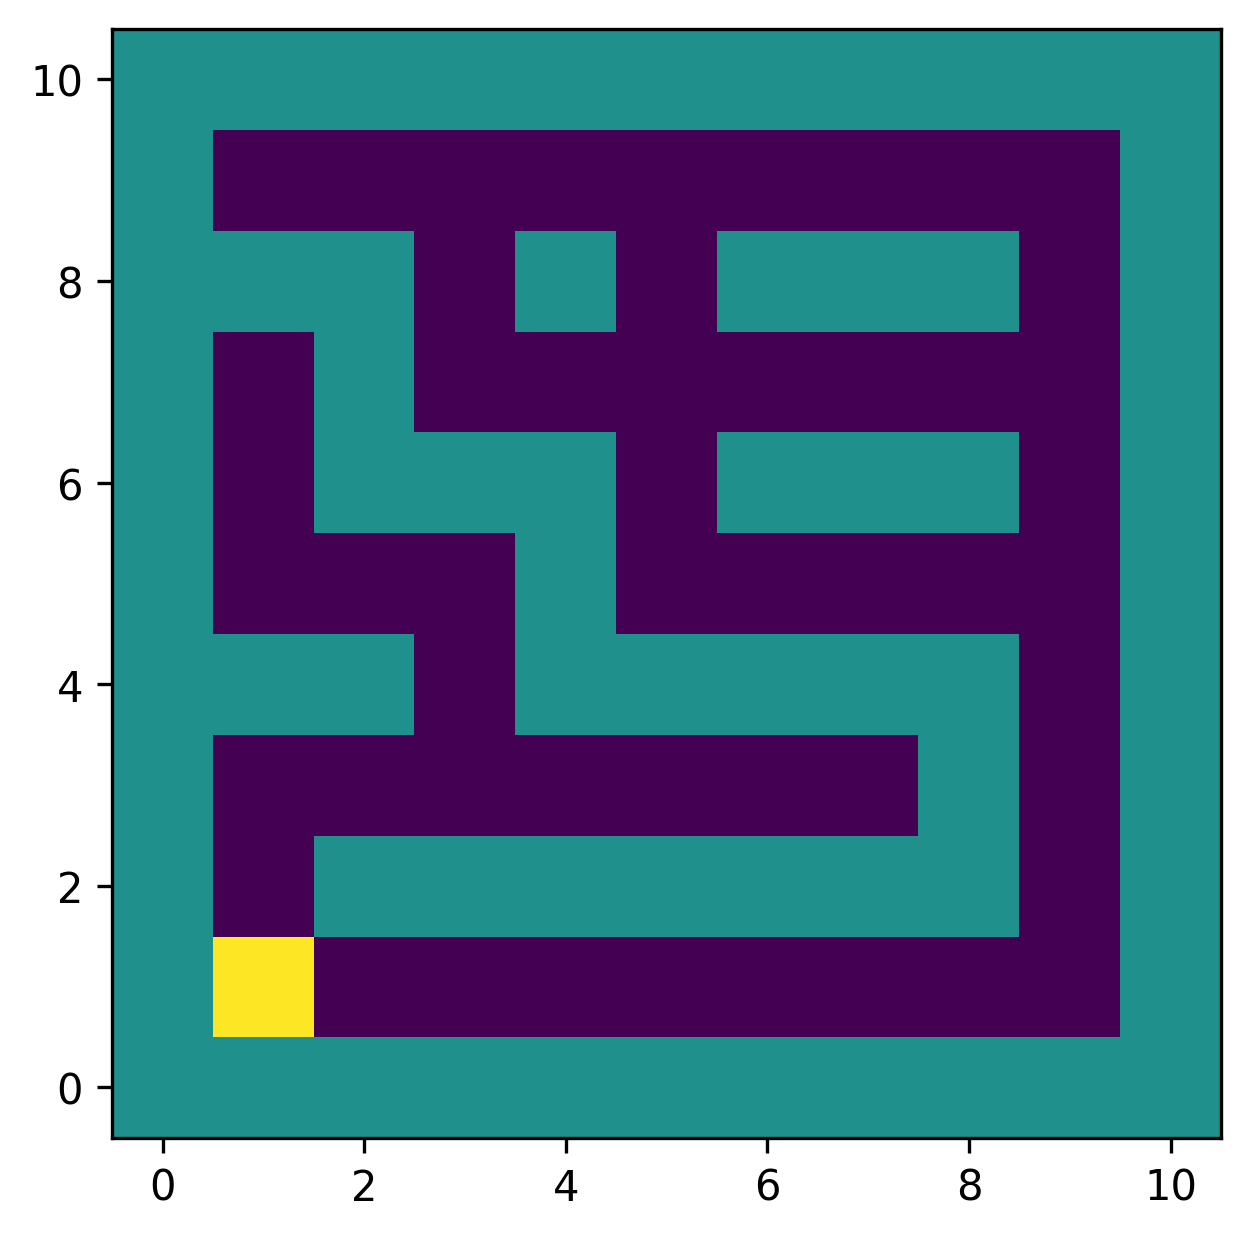

In [4]:
# make a maze, convert array from True/False to integer:
world=np.array(maze(width=11,height=11),dtype='int')

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# initial position
jx,jy=1,1

plt.figure(figsize=(5,5))
# take a random walk through the maze and animate this!
nsteps=100
for j in range(nsteps):
    # make a random step
    pick=np.random.randint(4)
    jx_new,jy_new=np.array([jx,jy])+directions[pick]
    if world[jx_new,jy_new]==0: # is empty, can move!
        jx,jy=jx_new,jy_new
        # show what's happening
        picture=np.copy(world) # copy the array (!)
        picture[jx,jy]=2
        plt.imshow(picture,origin='lower')
        plt.show()
        sleep(0.01)
        clear_output(wait=True)

#### Now: tabular REINFORCE

Remember from above that our gradient update step estimated by a single trajectory is
$$\delta\theta = \eta R \sum_{t} \nabla_\theta \ln \pi_{\theta}(a_t|s_t),$$
where $\eta$ is the learning rate.

Let's do a softmax-type parametrization:

So: $$\theta=(\theta_0,\theta_1,\theta_2,\theta_3)$$ and

$$\pi_{\theta}(s,a=j) = {e^{\theta_j} \over \sum_k e^{\theta_k}} $$

...where in reality the $\theta_j$ of course also depend on the state s, but for brevity we did not display that dependence here. They will all be stored in arrays, of the size of the maze!

So, we get:

$$ {\partial \over \partial \theta_l} \ln \pi_{\theta}(s,a=j) = \delta_{l,j}-\pi_{\theta}(s,a=l) $$


#### The policy gradient algorithm REINFORCE

In a few lines of pure python code, including visualization and comments. This implementation is optimized to be easy to understand, not for fast execution. 

You can find a JAX implementation of the same problem at the end of this notebook. As there are are are not many array operations in the code, it is not much faster.

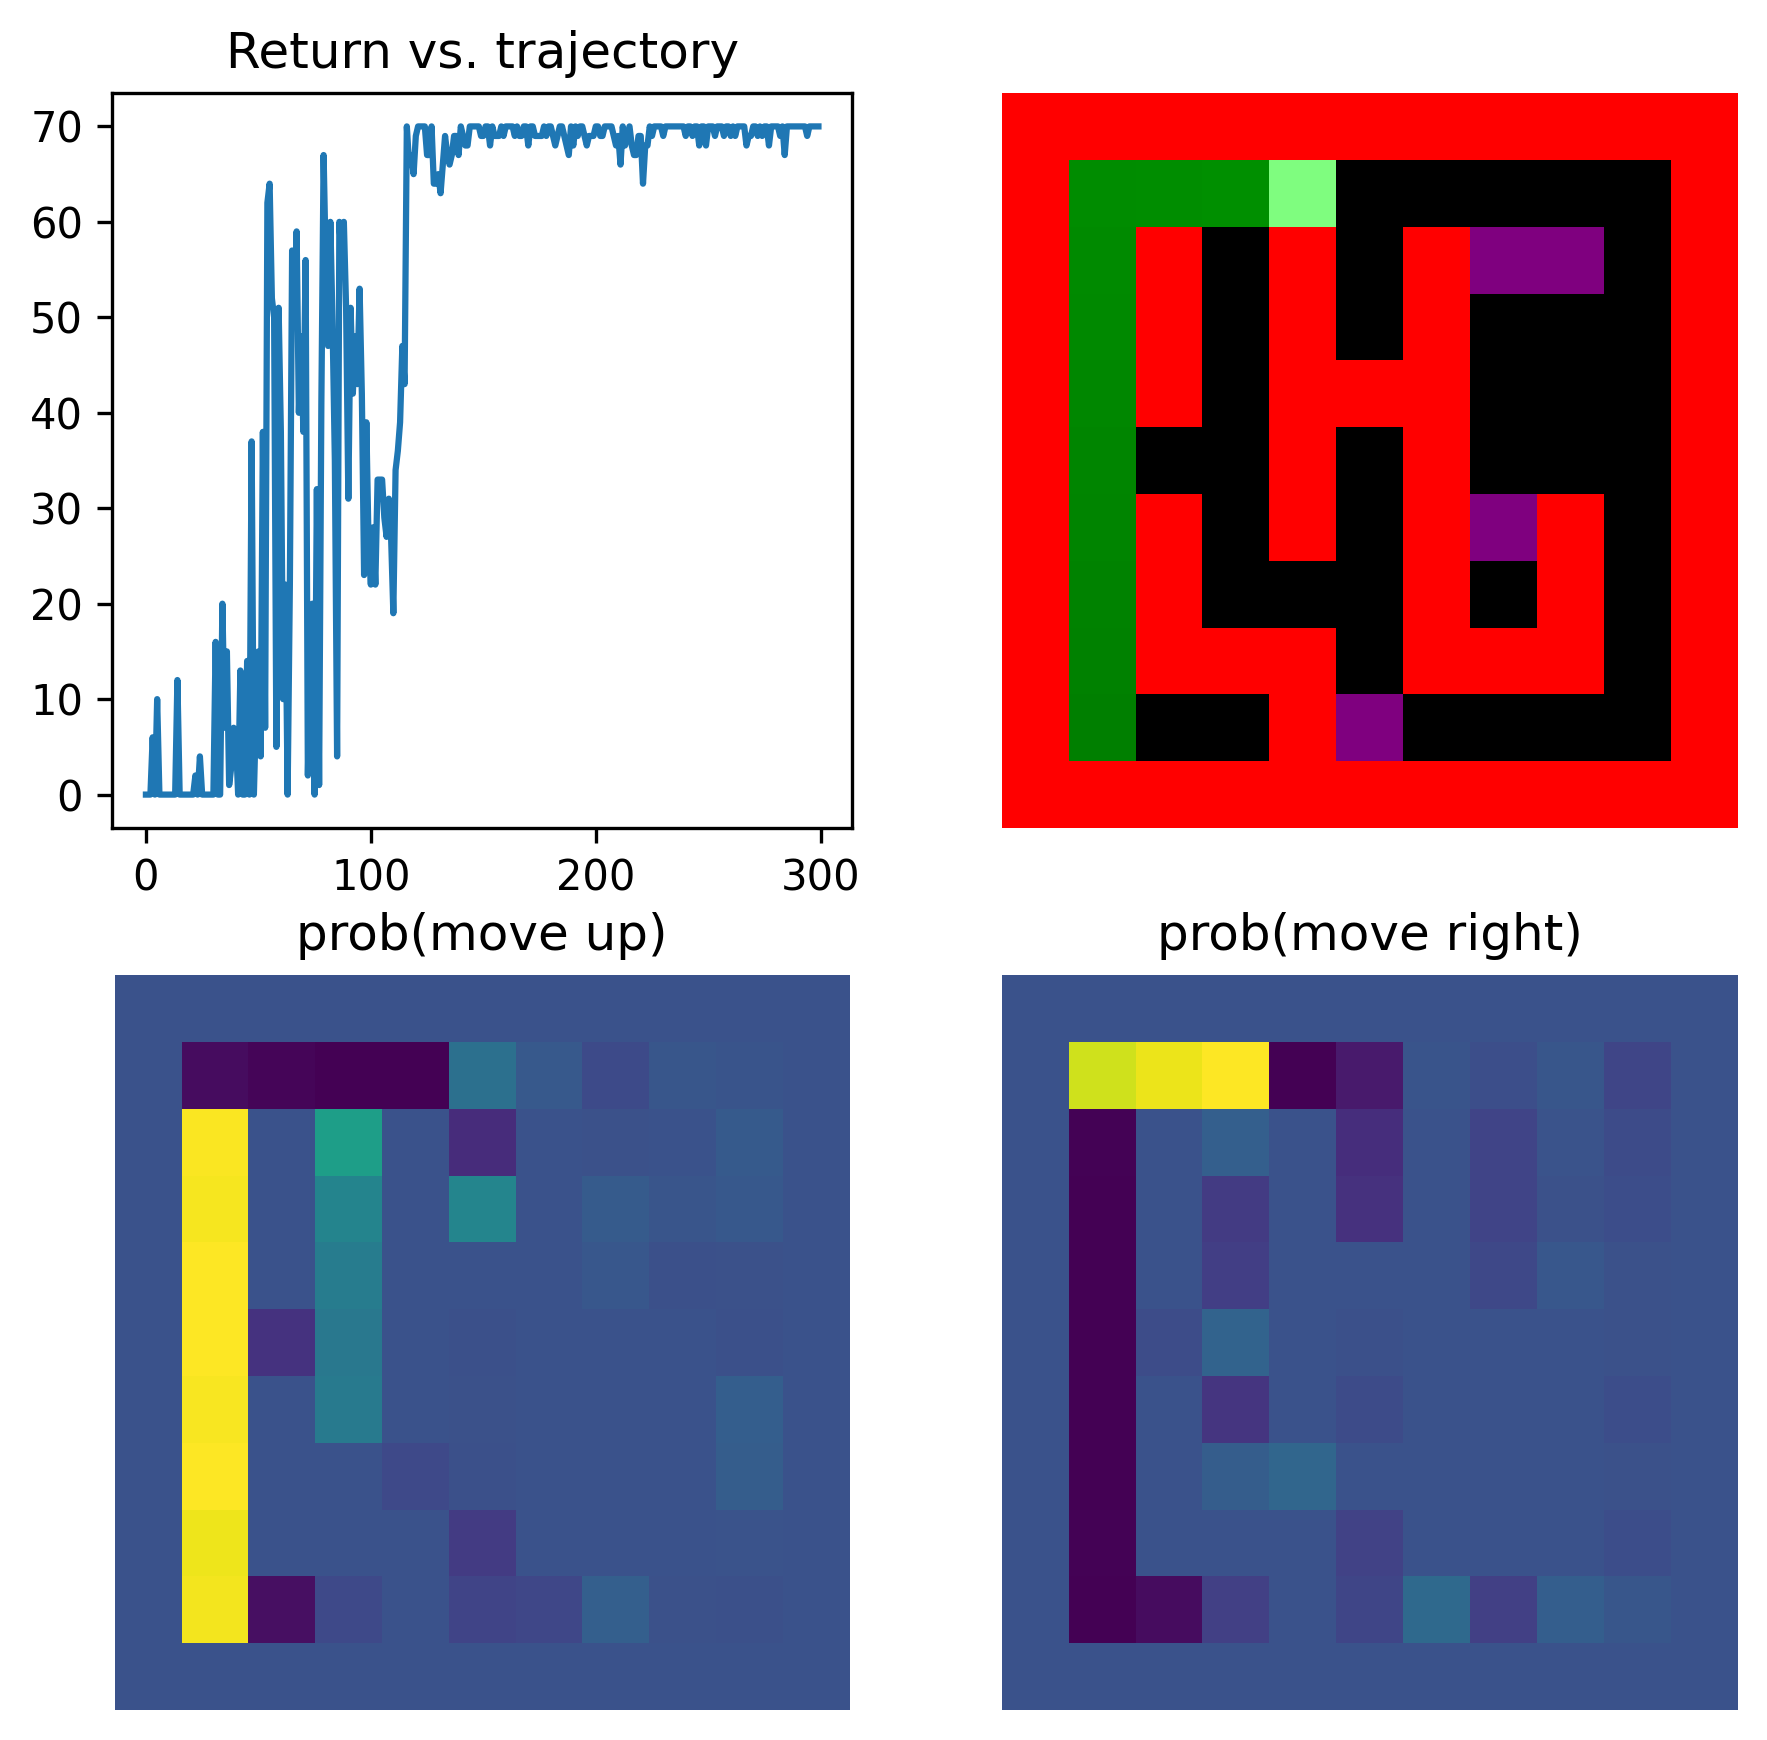

In [7]:
# full policy gradient RL for picking up 'treasure chests'
# in an automatically generated maze; 2020 by F.M. adapted 2024 by M.N.

seed=42
rng = np.random.default_rng(seed)


M=11 # the size of the world: M x M
eta=0.01 # the learning rate
num_chests=5 # number of treasure chests

# make a maze, convert array from True/False to integer:
world=np.array(maze(width=M,height=M),dtype='int')

# the four directions of motion [delta_jx,delta_jy]:
directions=np.array([[0,1],[0,-1],[1,0],[-1,0]])

# the policy probabilities as an array policy[state,action]
# here the state is represented by two coordinates jx,jy
policy=np.full([M,M,4],0.25)
# and also the underlying 'z'-values for the
# softmax parametrization:
policy_theta=np.full([M,M,4],0.0)

# steps inside one trajectory
nsteps=80

# total number of trajectorys, i.e. trajectories
n_trajectories=300
skipsteps=5 # don't plot every trajectory

# storing all the state/action pairs of the current trajectory
states=np.zeros([nsteps,2], dtype='int')
actions=np.zeros(nsteps, dtype='int')

# a map of rewards (the 'boxes' are here!)
reward=np.zeros([M,M])

# storing all the returns, for all trajectorys:
Returns=np.zeros(n_trajectories)


# random selection of reward sites (treasure chests)
n_treasures=0
while n_treasures < num_chests: 
    jx_target,jy_target=rng.integers(M,size=2)
    if jx_target>4 or jy_target>4: # stay away from starting point!
        if world[jx_target,jy_target]==0: # empty, keep it!
            reward[jx_target,jy_target]+=1
            n_treasures+=1

        
# train for ntrajectorys trajectories:
for trajectory in range(n_trajectories):

    # set return to zero for this trajectory:
    R=0
    # initial position:
    jx,jy=1,1
    
    # go through all time steps of a single trajectory
    for t in range(nsteps):
        # choose an action based on the policy:
        pick = rng.choice(4, p=policy[jx,jy,:])

        # record the move
        states[t,0]=jx
        states[t,1]=jy
        actions[t]=pick

        # now make the move
        jx_new,jy_new=np.array([jx,jy])+directions[pick]

        # really make it if there is no wall:
        if world[jx_new,jy_new]==0: # is empty, can move
            jx,jy=jx_new,jy_new
        
        # get a reward if on a treasure chest
        r=reward[jx,jy]
        R+=r
   
    # store the return
    Returns[trajectory]=R
    
    # use policy gradient update rule to adjust probabilities
    for t in range(nsteps): # go through the trajectory again
        a=actions[t] # remember the action taken at step t
        sx=states[t,0] # state/x-position at step
        sy=states[t,1] # state/y-position
        kronecker=np.zeros(4); kronecker[a]=1.0
        policy_theta[sx,sy,:]+=eta*R*(kronecker-policy[sx,sy,:])

    # now calculate (again) the policy probab. from the z-values
    policy=np.exp(policy_theta)
    policy/=np.sum(policy,axis=2)[:,:,None] # normalize
    # these two steps together implement softmax on every site. efficient array syntax
    
    # visualize
    if trajectory%skipsteps==0 or trajectory==n_trajectories-1:
        # show what's happened in this trajectory
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7,7))
        ax[0,0].plot(Returns) # all the returns, in all trajectorys
        ax[0,0].set_title("Return vs. trajectory")
        
        picture=np.zeros([M,M,3]) # last index: red/green/blue
        picture[:,:,0]=world # walls are red
        for j in range(nsteps): # highlight trajectory
            picture[states[j,0],states[j,1],1]=0.5*(1.0+(1.0*j)/nsteps)
        # put a bright pixel at the positions visited
        picture[:,:,2]+=0.5*reward # highlight the target sites!
        picture[:,:,0]+=0.5*reward

        # show picture (transpose is needed because
        # otherwise the first coordinate jx is plotted upwards,
        # not to the right)
        ax[0,1].imshow(np.transpose(picture,[1,0,2]),origin='lower')
        ax[0,1].axis('off')
        
        ax[1,0].imshow(np.transpose(policy[:,:,0]),origin='lower')
        ax[1,0].axis('off')
        ax[1,0].set_title("prob(move up)")
        ax[1,1].imshow(np.transpose(policy[:,:,2]),origin='lower')
        ax[1,1].set_title("prob(move right)")
        ax[1,1].axis('off')
        plt.show()

#### Tutorial Exercise: Change the algorithm so that the chests are "taken away" by the robot.

That is, the reward value at a given location should be set to zero after the agent has received the reward once (but you need to reinitialize to the old reward map for each new trajectory!)

Notice how the strategy looks now!

In principle, why would we need to change the size of our policy table (i.e. the size of our state space) to ensure that our task can still be formulated as a Markov Decision Process? For the sake of efficiency, we neglect this fact here. Can you think of situations (i.e. specific maze configurations) where this makes it impossible/difficult for our agent to learn the optimal policy?

#### Bonus Exercise: Think about other rules of the game!

The only constraint is that the best (or at least a good) strategy can be formulated based only on the position (e.g. wandering ghosts like in PacMan would be a problem for the robot)

#### Bonus Exercise: Do the update steps of the policy based on a batch of trajectories instead of only one trajectory. Can the agent train more efficiently now?

#### Bonus Exercise: Invent a game where the state needs to contain additional information (rather than just the position jx,jy)!

...but in such a way that it can still be handled with a table.

#### JAX Version of the code:

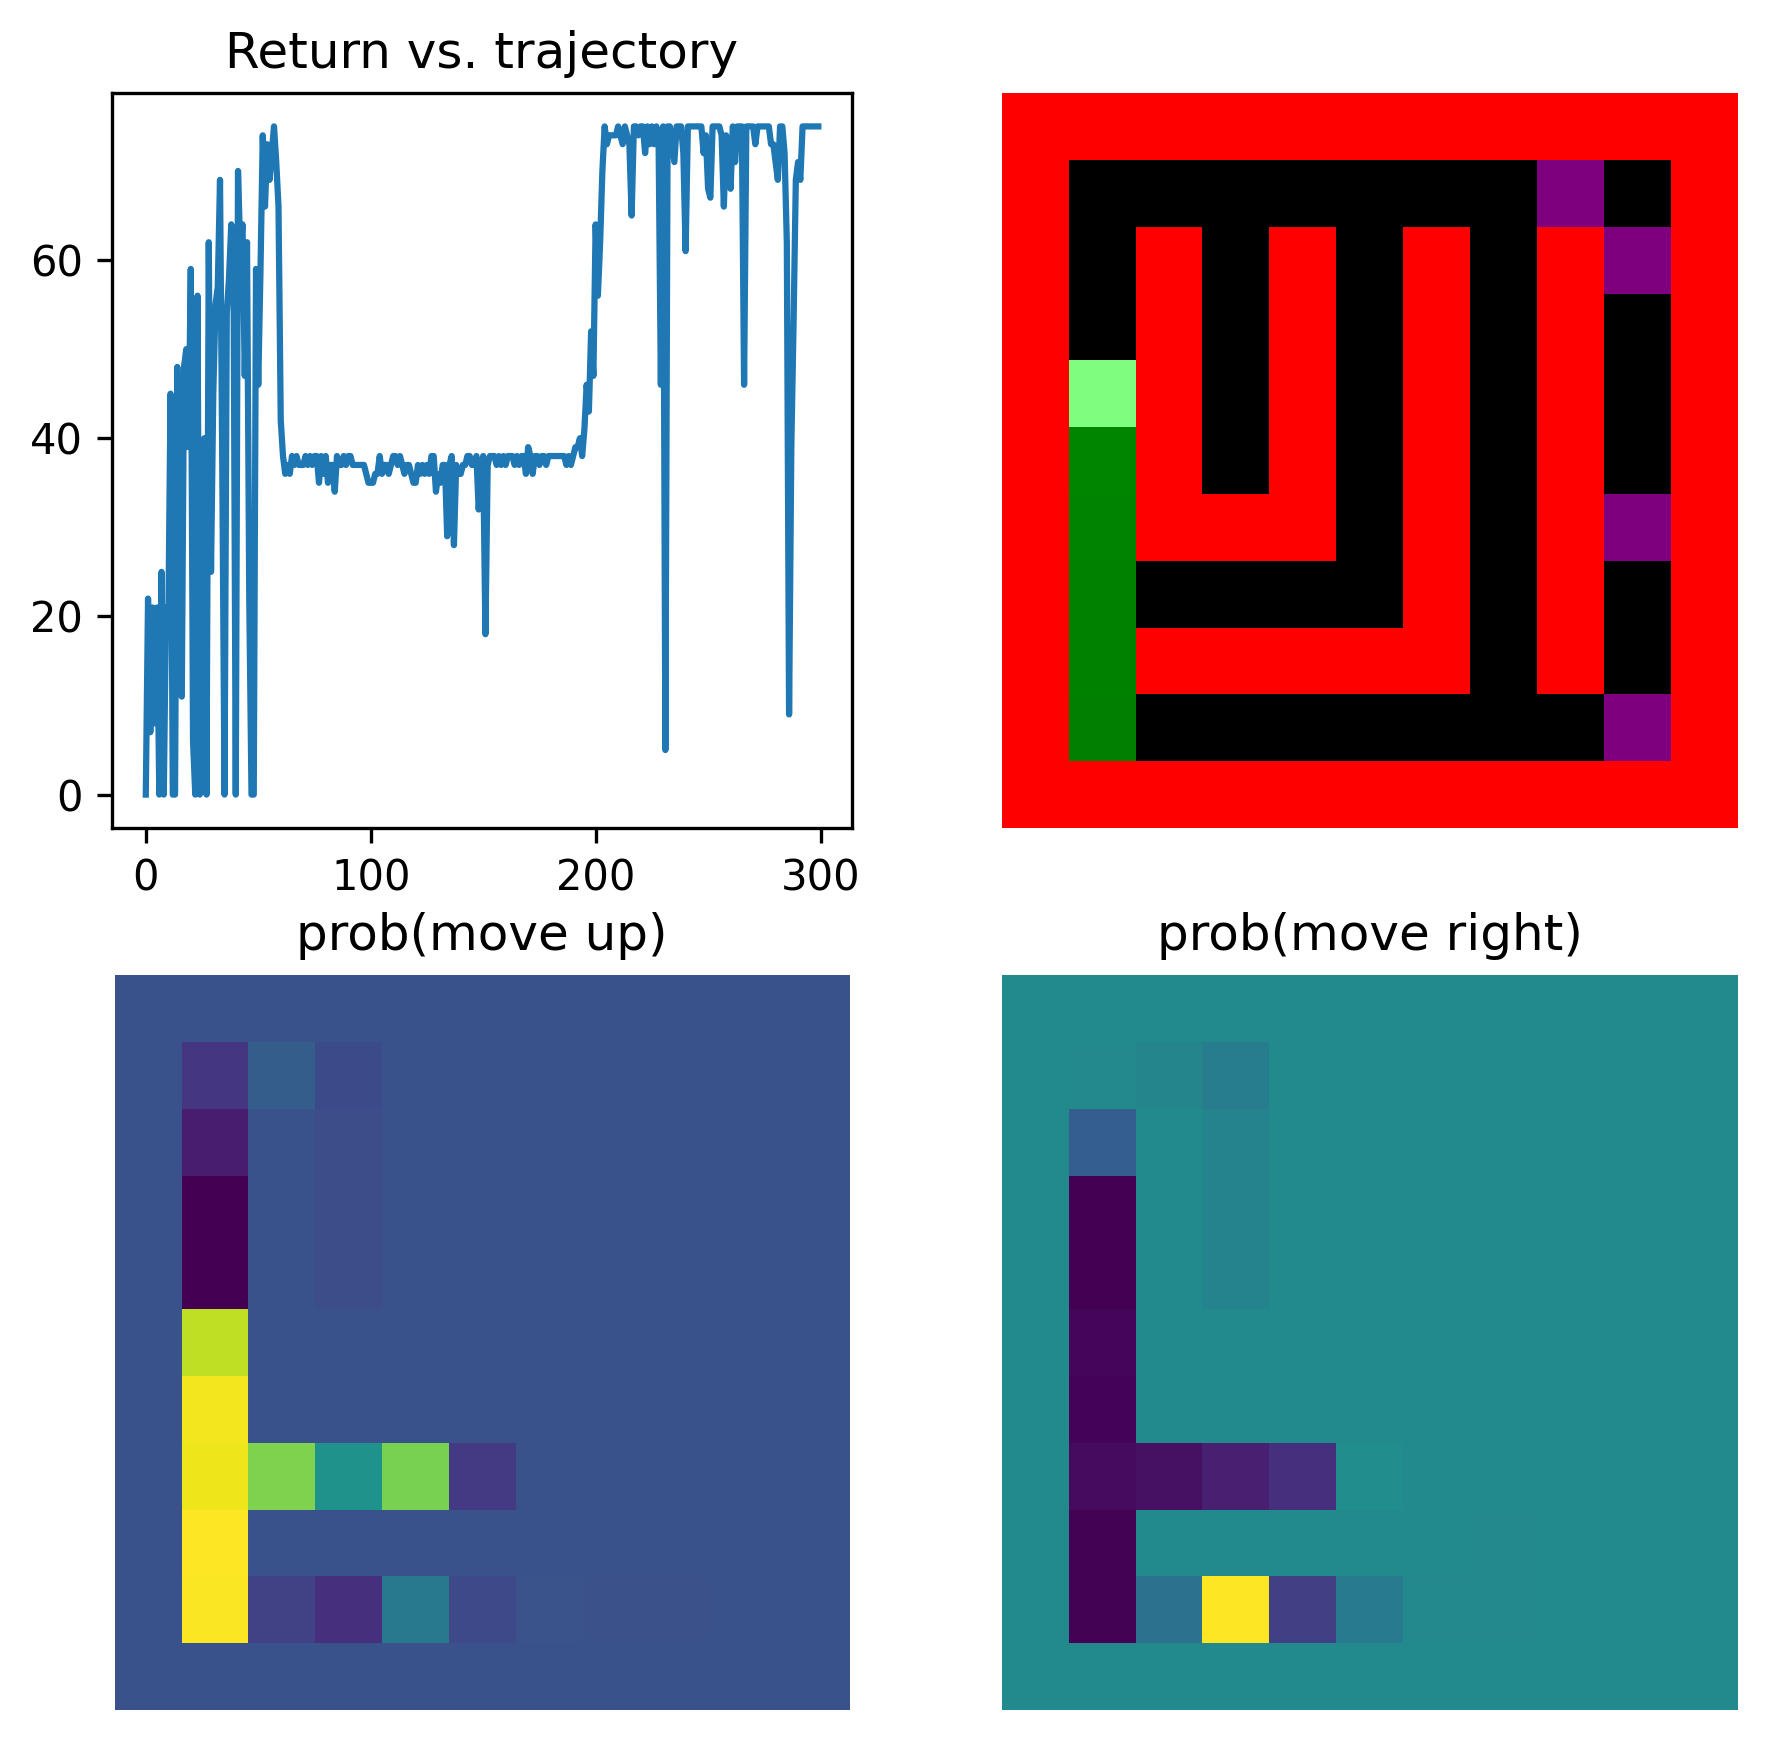

In [9]:
# full policy gradient RL for picking up 'treasure chests'
# in an automatically generated maze; adapted from the code above 2024 by M.N.
# As there are barely any vectorized operations, this is not actually much faster than the numpy version
# but it is a good exercise in using for loops in JAX

seed = 0
key = jax.random.PRNGKey(seed)


M=11 # the size of the world: M x M
eta=0.01 # the learning rate
num_chests=5 # number of treasure chests

# make a maze, convert array from True/False to integer:
world=jnp.array(maze(width=M,height=M),dtype='int32')

# the four directions of motion [delta_jx,delta_jy]:
directions=jnp.array([[0,1],[0,-1],[1,0],[-1,0]])

# the policy paremeters of the underlying softmax parametrization as an array policy_theta[state,action]
# softmax parametrization:
policy_theta=jnp.full([M,M,4],0.0)

# steps inside one trajectory
nsteps=80

# total number of trajectorys, i.e. trajectories
n_trajectories=300
skipsteps=5 # don't plot every trajectory

# storing all the returns, for all trajectorys:
Returns=[]

# a map of rewards (the 'boxes' are here!)
reward=np.zeros([M,M])
# random selection of reward sites (treasure chests)
n_treasures=0
while n_treasures < num_chests: 
    key, subkey = jax.random.split(key)
    jx_target,jy_target=jax.random.randint(subkey, minval=0, maxval=M, shape=(2,))
    if jx_target>4 or jy_target>4: # stay away from starting point!
        if world[jx_target,jy_target]==0: # empty, keep it!
            reward[jx_target,jy_target]+=1
            n_treasures+=1
reward = jnp.array(reward)

@jax.jit
def train_step(key, policy_theta):
    # initial position:
    pos=jnp.array([1,1], dtype='int32')
    # compute probabilities from policy_theta
    policy=jnp.exp(policy_theta)
    policy/=jnp.sum(policy,axis=2)[:,:,None] # normalize

    # use lax.scan to go through all time steps of a single trajectory
    def step(key_pos, _):
        key, pos = key_pos
        # make a step, according to the policy distribution
        key, subkey = jax.random.split(key)
        pick = jax.random.choice(subkey, 4, p=policy[pos[0], pos[1]])
        # record the move
        pos_new=pos+directions[pick]
        # now make the move
        pos_new=world[pos_new[0], pos_new[1]] * pos + (1 - world[pos_new[0], pos_new[1]]) * pos_new
        # get a reward if on a treasure chest!
        r=reward[pos[0], pos[1]]
        # arguments for next function call, results to log
        return (key, pos_new), (pos, pick, r)
    
    key, subkey = jax.random.split(key)
    _, (states, actions, rews) = jax.lax.scan(step, (subkey, pos), None, length=nsteps)
    R = jnp.sum(rews)

    # use policy gradient update rule to adjust probabilities using lax.scan
    kronecker = jnp.eye(4)
    def update_policy(last_policy_theta, state_action):
        state, action = state_action
        # using .at[] ... .set() guarantees fast in-place updates if jitted
        last_policy_theta = last_policy_theta.at[state[0], state[1]].set(last_policy_theta[state[0], state[1]]
                                                                        + eta*R * (kronecker[action] - policy[state[0], state[1]]))
        # argument for next function call, nothing to log here
        return last_policy_theta, None
    policy_theta, _ = jax.lax.scan(update_policy, policy_theta, (states, actions))

    return policy_theta, R, states, actions

for trajectory in range(n_trajectories):

    # train one step
    key, subkey = jax.random.split(key)
    policy_theta, R, states, actions = train_step(subkey, policy_theta)
    Returns.append(R)
    

    # visualize!
    if trajectory%skipsteps==0 or trajectory==n_trajectories-1:
        policy=jnp.exp(policy_theta)
        policy/=jnp.sum(policy,axis=2)[:,:,None] # normalize
        # show what's happened in this trajectory
        clear_output(wait=True)
        fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(7,7))
        ax[0,0].plot(Returns) # all the returns, in all trajectorys
        ax[0,0].set_title("Return vs. trajectory")
        
        picture=np.zeros([M,M,3]) # last index: red/green/blue
        picture[:,:,0]=world # walls are red
        for j in range(nsteps): # highlight trajectory
            picture[states[j,0],states[j,1],1]=0.5*(1.0+(1.0*j)/nsteps)
        # put a bright pixel at the positions visited
        picture[:,:,2]+=0.5*reward # highlight the target sites!
        picture[:,:,0]+=0.5*reward

        # show picture (transpose is needed because
        # otherwise the first coordinate jx is plotted upwards,
        # not to the right)
        ax[0,1].imshow(np.transpose(picture,[1,0,2]),origin='lower')
        ax[0,1].axis('off')
        
        ax[1,0].imshow(np.transpose(policy[:,:,0]),origin='lower')
        ax[1,0].axis('off')
        ax[1,0].set_title("prob(move up)")
        ax[1,1].imshow(np.transpose(policy[:,:,2]),origin='lower')
        ax[1,1].set_title("prob(move right)")
        ax[1,1].axis('off')
        plt.show()